## Chain

### Goals
Now, let's build up to a simple chain that combines 4 concepts:
- Using chat messages as our graph state
- Using chat models in graph nodes
- Binding tools to our chat model
- Executing tool calls in graph nodes


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

### Messages
- HumanMessage, AIMessage, SsytemMessage, ToolMessage
  
- Each message can be supplied with a few tings:
  - content
  - name
  - response_metadata (optionally)

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researcing ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(AIMessage(content="Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researcing ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


### Chat Models
Leet's check chat your `GOOGLE_API_KEY`

In [2]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
# set proxy
_set_env("PROXY_VALUE")
proxy = os.getenv("PROXY_VALUE")
for proxy_var in ['HTTP_PROXY', 'HTTPS_PROXY', 'http_proxy', 'https_proxy']:
    os.environ[proxy_var] = proxy
# GOOGLE API KEY
_set_env("GOOGLE_API_KEY")

print(os.environ["PROXY_VALUE"], "Hi")

http://localhost:7897 Hi


In [8]:
%pip install -qU langchain-google-genai


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Now we can instantiate our model object and gnerate hat completions
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2,
    max_tokens=512,
    timeout=None,
    max_retries=2
)
result = llm.invoke(messages)
type(result)
print(result)

content='There\'s no single "best" place to see orcas in the US, as it depends on the time of year and what kind of experience you\'re looking for.  Orcas (killer whales) have different populations with varying ranges.  However, some of the most popular and reliable locations include:\n\n* **Alaska:** This is arguably the best overall location for orca viewing in the US.  Several different populations of orcas frequent Alaskan waters, offering excellent opportunities for sightings.  Specific locations include:\n    * **Southeast Alaska:**  Offers opportunities to see both resident and transient orcas.  Cruises are common from Juneau, Ketchikan, and other towns.\n    * **Prince William Sound:** Known for its resident orca pods.\n    * **Kenai Fjords National Park:**  Offers a chance to see orcas alongside other wildlife.\n\n* **Washington State:** The Salish Sea, particularly around the San Juan Islands, is famous for its resident orca population (Southern Resident Killer Whales).  Thes

In [20]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

### Tools
Tools are useful whenever you want a model to interact with external systems.
External systems (e.g., APIs) often require a particular input schema or playload, rather than natural language.
When we buind an API, fro example, as a tool we given the model awareness of the required input schema.
The model will choose to call a tool based upon the natural language input from the user.
And, it will reurn an output that adheres to the tools schema.
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`

Let's showcase a simple example of tool calling

In [4]:
# The multiple function is our tool
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.

    Args:
        a: first int 
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])
    

If we pass an input - e.g., "What is 3 multiplied by 7 " -we see a tool call returned.
The tool call has specific arguments that match the input schema of our function along with the name of the funtion to call.
`{'arguments': '{"a": 3, "b": 7}', "name": 'multiply'}`

In [5]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 3 multiplied by 7", name="BiaoGe")])
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 7.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e910f471-9d16-430e-bb3d-95c6f9ed9228-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 7.0}, 'id': 'd7702d65-c0fe-4fed-ae00-e08491a79fb8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 3, 'total_tokens': 60, 'input_token_details': {'cache_read': 0}})

In [6]:
tool_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 3.0, "b": 7.0}'}

### Using messages as state
With these fundations in place, we can now use `messages` in our graph state.
Let's define our state, `MessagesState`, as a `TypeDict` with a single key: `messages`.
`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [8]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

### Reducers
Now, we have a minor problem!
As we discussed, each node will return a new value for our state key `messages`.
But, this new value will override to the prior `messages` value.
As our graph runs, we want to append message to our `messages` state key.
We can use `reducer functions` address this.
Reducers allow us to specify how state updates are performed.
If no reducer function is sepcifed, then it is assumed that updates to the key should override it as we saw before.
But, to append messages, we can use the pre-build add_messages reducer.
The ensures that any messges are appended to the existing list of messages
We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata

In [9]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common. LangGraph has a pre-build `MessageSate`
`MessagesState` is defined:

- With a pre-build single `messages` key
- This is a list of `AnyMessage` objects
- It uses the `add_messages` reducer
We'll usually use `MessagesState` because it is less verbose than defining a custom `TypeDict` as shown above.


In [10]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed byond messages, which is pre-build
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [11]:
# initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="BiaoGe")
]

# New message to add 
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test 
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='76536344-809a-4c8d-8edb-e2364e5222be'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='BiaoGe', id='fb4cc9f8-93b9-4fc7-8523-6ea5ee2cfbcd'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='04746534-8da3-4062-8aa0-8ac93fa2e551')]

### Our graph
Now, lets use `MessagesState` with a graph.

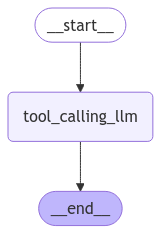

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View 
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello`, the LLM responds without any tool calls.

In [13]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you?


The LLM chooses to use tool when it determines that the input or task requires the functionality provided by that tool.



In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 3 and 7")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (b31fb29e-75da-4729-9841-d428362c774f)
 Call ID: b31fb29e-75da-4729-9841-d428362c774f
  Args:
    a: 3.0
    b: 7.0
